# Kim Lab NWB Reader

This notebook demonstrates how to read and explore NWB files created by the Kim Lab's conversion script.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pynwb import read_nwb
from pathlib import Path

## Load the NWB file

First, specify the path to your NWB file and load it using the NWBHDF5IO reader.

In [3]:
# Replace with the path to your NWB file
nwb_file_path = Path("/home/heberto/cohen_project/Sample data/Kim Lab/nwb/20250301b_00007.nwb")

# Open the NWB file
nwbfile = read_nwb(nwb_file_path)

## Explore file metadata

Let's first look at the general metadata in the NWB file.

In [4]:
# Display general file metadata
print(f"NWB File: {nwbfile.identifier}")
print(f"Session ID: {nwbfile.session_id}")
print(f"Session Description: {nwbfile.session_description}")
print(f"Session Start Time: {nwbfile.session_start_time}")

# Display subject information if available
if nwbfile.subject is not None:
    print("\nSubject Information:")
    print(f"Subject ID: {nwbfile.subject.subject_id}")
    if hasattr(nwbfile.subject, 'age'):
        print(f"Age: {nwbfile.subject.age}")
    if hasattr(nwbfile.subject, 'sex'):
        print(f"Sex: {nwbfile.subject.sex}")
    if hasattr(nwbfile.subject, 'genotype') and nwbfile.subject.genotype is not None:
        print(f"Genotype: {nwbfile.subject.genotype}")
    if hasattr(nwbfile.subject, 'strain') and nwbfile.subject.strain is not None:
        print(f"Strain: {nwbfile.subject.strain}")

NWB File: 3051562d-0be6-44a5-b7b8-d708daa754af
Session ID: 20250301b_00007
Session Description:  protocol: data_collection_20250105.m
Session Start Time: 2025-03-01 00:00:00-08:00

Subject Information:
Subject ID: 20250301b_00007
Age: P6.0D
Sex: F
Strain: R38C04>GCamp7f


## Explore devices and imaging metadata

The Kim Lab NWB file contains metadata about the two-photon imaging system and other devices.

In [5]:
# Display devices
print("Devices:")
for device_name, device in nwbfile.devices.items():
    print(f"- {device_name}")
    if hasattr(device, 'description') and device.description is not None:
        print(f"  Description: {device.description}")
    if hasattr(device, 'manufacturer') and device.manufacturer is not None:
        print(f"  Manufacturer: {device.manufacturer}")

Devices:
- Microscope
- NI 782258-01
  Description: Multifunction DAQ device with USB 2.0 connectivity. 32 single-ended or 16 differential analog inputs (16-bit resolution), 4 analog outputs (±10V, 16-bit resolution), 32 digital I/O, 16 bidirectional channels, 4 counter/timers, 1 MS/s sampling rate.
  Manufacturer: National Instruments (NI)


In [6]:
# Display imaging plane information
if hasattr(nwbfile, 'imaging_planes') and len(nwbfile.imaging_planes) > 0:
    print("\nImaging Planes:")
    for plane_name, plane in nwbfile.imaging_planes.items():
        print(f"- {plane_name}")
        print(f"  Description: {plane.description}")
        if hasattr(plane, 'indicator') and plane.indicator is not None:
            print(f"  Indicator: {plane.indicator}")
        if hasattr(plane, 'location') and plane.location is not None:
            print(f"  Location: {plane.location}")
        if hasattr(plane, 'excitation_lambda') and plane.excitation_lambda is not None:
            print(f"  Excitation Lambda: {plane.excitation_lambda} nm")
        
        # Display optical channel information
        for i, channel in enumerate(plane.optical_channel):
            print(f"  Optical Channel {i+1}: {channel.name}")
            print(f"    Description: {channel.description}")
            if hasattr(channel, 'emission_lambda') and channel.emission_lambda is not None:
                print(f"    Emission Lambda: {channel.emission_lambda} nm")


Imaging Planes:
- ImagingPlane
  Description: The plane or volume being imaged by the microscope.
  Indicator: unknown
  Location: unknown
  Excitation Lambda: nan nm
  Optical Channel 1: Channel 1
    Description: An optical channel of the microscope.
    Emission Lambda: nan nm


## Explore behavioral data

The Kim Lab NWB file contains behavioral data including wingbeat amplitude and flight dynamics.

In [7]:
# List all acquisition data
print("Available acquisition data:")
for name in nwbfile.acquisition:
    print(f"- {name}")

Available acquisition data:
- LeftRightWingbeatSeries
- LeftWingbeatSeries
- StimulusPositionSeries
- TwoPhotonSeries
- Video 20250301b_00007


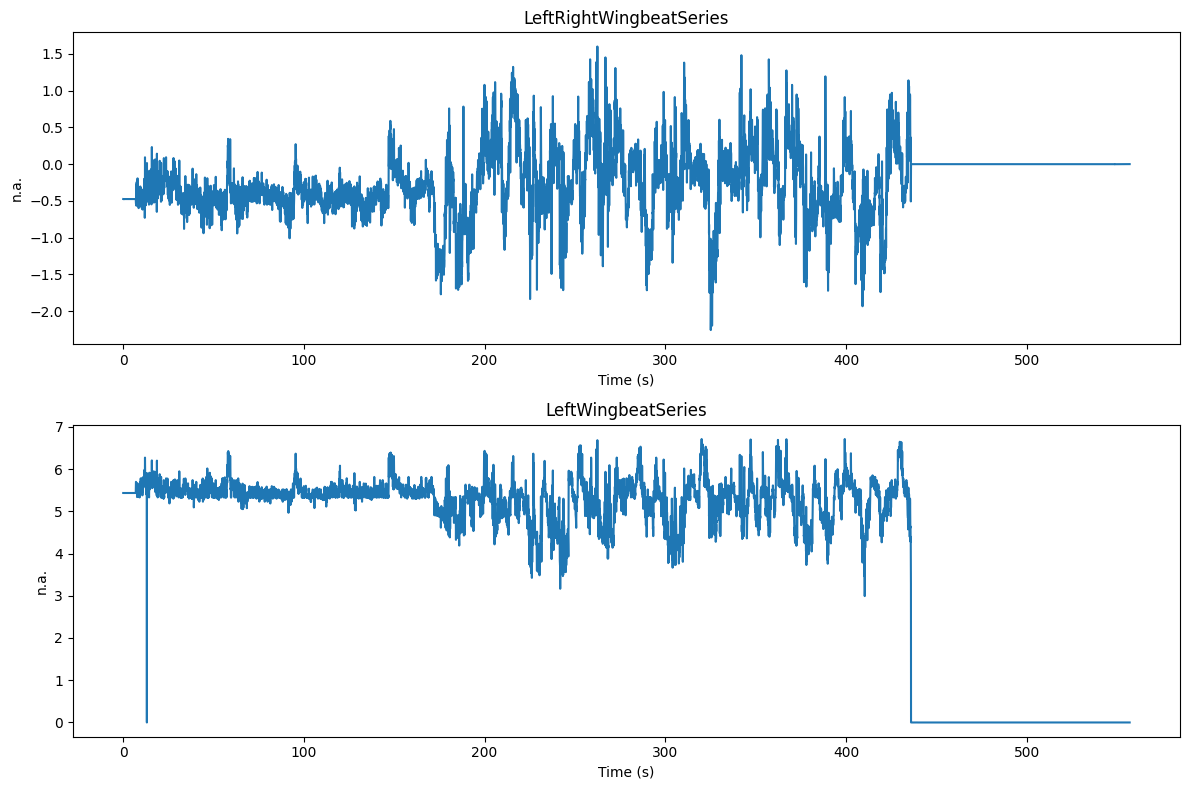

In [8]:
# Plot wing kinematics data (if available)
wing_data_names = [name for name in nwbfile.acquisition if 'wing' in name.lower()]

if wing_data_names:
    plt.figure(figsize=(12, 8))
    for i, name in enumerate(wing_data_names):
        data = nwbfile.acquisition[name]
        plt.subplot(len(wing_data_names), 1, i+1)
        
        # Get timestamps and data
        timestamps = data.timestamps[:] if data.timestamps is not None else np.arange(len(data.data))
        
        # Plot a subset of the data to avoid overwhelming the plot
        max_points = 10000
        if len(timestamps) > max_points:
            step = len(timestamps) // max_points
            plt.plot(timestamps[::step], data.data[::step])
        else:
            plt.plot(timestamps, data.data[:])
        
        plt.title(name)
        plt.xlabel('Time (s)')
        plt.ylabel(f'{data.unit}')
    
    plt.tight_layout()
    plt.show()
else:
    print("No wing kinematics data found in the file.")

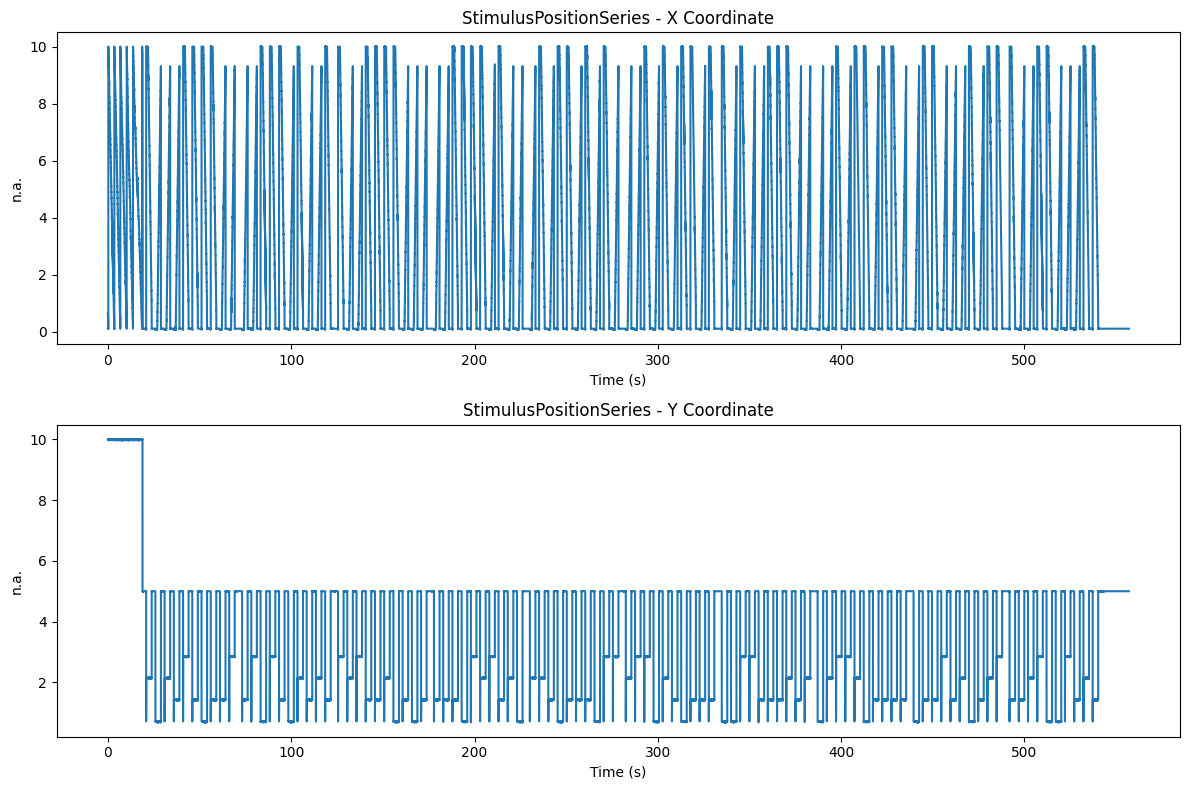

In [9]:
# Plot stimulus position data (if available)
position_data_names = [name for name in nwbfile.acquisition if 'position' in name.lower() or 'stimulus' in name.lower()]

if position_data_names:
    plt.figure(figsize=(12, 8))
    for i, name in enumerate(position_data_names):
        data = nwbfile.acquisition[name]
        
        # Get timestamps and data
        timestamps = data.timestamps[:] if data.timestamps is not None else np.arange(len(data.data))
        
        # Check if data is 2D (X and Y coordinates)
        if len(data.data.shape) > 1 and data.data.shape[1] == 2:
            plt.subplot(2, 1, 1)
            plt.plot(timestamps, data.data[:, 0], label=f"{name} - X")
            plt.title(f"{name} - X Coordinate")
            plt.xlabel('Time (s)')
            plt.ylabel(f'{data.unit}')
            
            plt.subplot(2, 1, 2)
            plt.plot(timestamps, data.data[:, 1], label=f"{name} - Y")
            plt.title(f"{name} - Y Coordinate")
            plt.xlabel('Time (s)')
            plt.ylabel(f'{data.unit}')
        else:
            plt.plot(timestamps, data.data[:], label=name)
            plt.title(name)
            plt.xlabel('Time (s)')
            plt.ylabel(f'{data.unit}')
    
    plt.tight_layout()
    plt.show()
else:
    print("No stimulus position data found in the file.")

## Explore two-photon imaging data

The Kim Lab NWB file contains two-photon calcium imaging data.

In [10]:
# Check for two-photon series data
two_photon_series = [name for name in nwbfile.acquisition if 'two_photon' in name.lower() or 'twophoton' in name.lower()]

if two_photon_series:
    print("Two-Photon Series in acquisition:")
    for name in two_photon_series:
        data = nwbfile.acquisition[name]
        print(f"- {name}")
        if hasattr(data, 'description') and data.description is not None:
            print(f"  Description: {data.description}")
        if hasattr(data, 'data') and data.data is not None:
            print(f"  Data shape: {data.data.shape}")
        if hasattr(data, 'imaging_plane') and data.imaging_plane is not None:
            print(f"  Imaging plane: {data.imaging_plane.name}")
        if hasattr(data, 'rate') and data.rate is not None:
            print(f"  Rate: {data.rate} Hz")
        if hasattr(data, 'unit') and data.unit is not None:
            print(f"  Unit: {data.unit}")
else:
    print("No two-photon series found in acquisition.")

Two-Photon Series in acquisition:
- TwoPhotonSeries
  Description: {"frameNumbers": "1", "acquisitionNumbers": "1", "frameNumberAcquisition": "1", "frameTimestamps_sec": "0.000000000", "acqTriggerTimestamps_sec": "-0.000026065", "nextFileMarkerTimestamps_sec": "-1.000000000", "endOfAcquisition": "0", "endOfAcquisitionMode": "0", "dcOverVoltage": "0", "epoch": "[2025  3  1 12 32 9.176]", "auxTrigger0": "[]", "auxTrigger1": "[]", "auxTrigger2": "[]", "auxTrigger3": "[]", "I2CData": "{}", "SI.LINE_FORMAT_VERSION": "1", "SI.PREMIUM": "true", "SI.TIFF_FORMAT_VERSION": "4", "SI.VERSION_COMMIT": "'2af5d7cfec2f1f15c7a4f5cfcb6b56de9e5d4a1d'", "SI.VERSION_MAJOR": "2021", "SI.VERSION_MINOR": "1", "SI.VERSION_UPDATE": "0", "SI.acqState": "'grab'", "SI.acqsPerLoop": "1", "SI.errorMsg": "''", "SI.extTrigEnable": "false", "SI.fieldCurvatureRxs": "[]", "SI.fieldCurvatureRys": "[]", "SI.fieldCurvatureTilt": "0", "SI.fieldCurvatureTip": "0", "SI.fieldCurvatureZs": "[]", "SI.hBeams.enablePowerBox": "fals

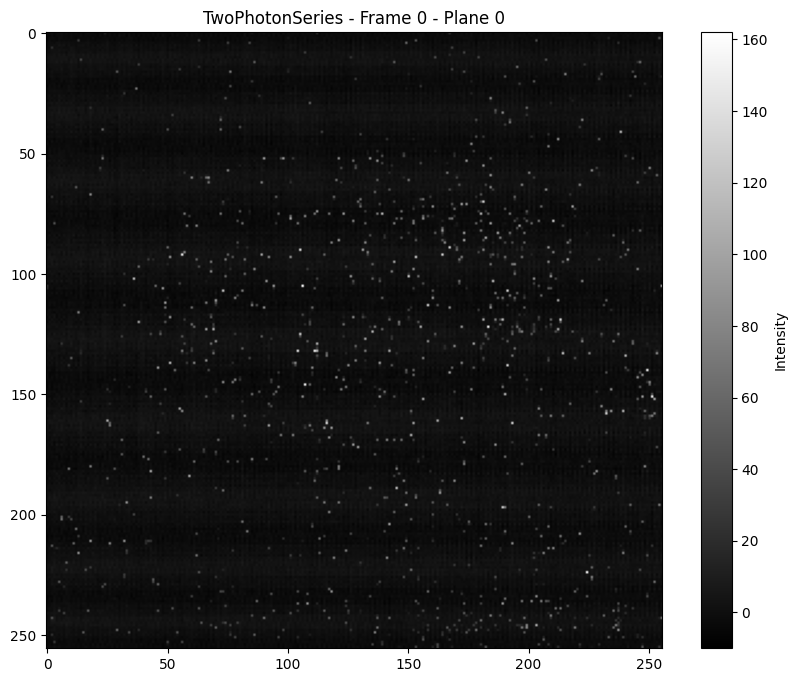

Displayed frame 0 from TwoPhotonSeries
Frame shape: (256, 256, 21)


In [13]:
# Visualize a frame from the two-photon imaging data if available
plane_index = 0
if two_photon_series:
    for name in two_photon_series:
        data = nwbfile.acquisition[name]
        
        # Get a single frame (the first one)
        frame_index = 0
        frame = data.data[frame_index]
        
        plt.figure(figsize=(10, 8))
        plt.imshow(frame[..., plane_index], cmap='gray')
        plt.title(f"{name} - Frame {frame_index} - Plane {plane_index}")
        plt.colorbar(label='Intensity')
        plt.show()
        
        print(f"Displayed frame {frame_index} from {name}")
        print(f"Frame shape: {frame.shape}")
else:
    print("No two-photon series data found to visualize.")

## Explore ROI data

The Kim Lab NWB file may contain ROI fluorescence traces and coordinates.

In [ ]:
# Check for ROI data in processing modules
if hasattr(nwbfile, 'processing') and len(nwbfile.processing) > 0:
    print("Processing modules:")
    for module_name, module in nwbfile.processing.items():
        print(f"- {module_name}")
        if hasattr(module, 'description') and module.description is not None:
            print(f"  Description: {module.description}")
        
        # List data interfaces in the module
        print("  Data interfaces:")
        for data_name, data_interface in module.data_interfaces.items():
            print(f"  - {data_name} ({type(data_interface).__name__})")
            
            # If it's a ROI table, print more details
            if 'roi' in type(data_interface).__name__.lower() or 'plane' in type(data_interface).__name__.lower():
                if hasattr(data_interface, 'description') and data_interface.description is not None:
                    print(f"    Description: {data_interface.description}")
                
                # Check for ROI table
                if hasattr(data_interface, 'rois') and data_interface.rois is not None:
                    print(f"    Number of ROIs: {len(data_interface.rois)}")
                    print(f"    ROI columns: {list(data_interface.rois.colnames)}")
                
                # Check for fluorescence traces
                if hasattr(data_interface, 'roi_response_series') and data_interface.roi_response_series is not None:
                    print(f"    Number of ROI response series: {len(data_interface.roi_response_series)}")
                    
                    # Print details for each ROI response series
                    for series_name, series in data_interface.roi_response_series.items():
                        print(f"    - {series_name}")
                        if hasattr(series, 'description') and series.description is not None:
                            print(f"      Description: {series.description}")
                        if hasattr(series, 'data') and series.data is not None:
                            print(f"      Data shape: {series.data.shape}")
else:
    print("No processing modules found in the file.")

{}

In [ ]:
# Plot ROI fluorescence traces if available
roi_response_series = None

# Find ROI response series in processing modules
if hasattr(nwbfile, 'processing') and len(nwbfile.processing) > 0:
    for module_name, module in nwbfile.processing.items():
        for data_name, data_interface in module.data_interfaces.items():
            if hasattr(data_interface, 'roi_response_series') and data_interface.roi_response_series is not None:
                for series_name, series in data_interface.roi_response_series.items():
                    roi_response_series = series
                    break
                if roi_response_series is not None:
                    break
        if roi_response_series is not None:
            break

if roi_response_series is not None:
    # Get timestamps and data
    timestamps = roi_response_series.timestamps[:] if roi_response_series.timestamps is not None else np.arange(len(roi_response_series.data))
    data = roi_response_series.data[:]
    
    # Plot fluorescence traces for a subset of ROIs
    num_rois_to_plot = min(5, data.shape[0])  # Plot up to 5 ROIs
    
    plt.figure(figsize=(12, 8))
    for i in range(num_rois_to_plot):
        plt.plot(timestamps, data[i], label=f"ROI {i}")
    
    plt.title(f"{series_name} - ROI Fluorescence Traces")
    plt.xlabel('Time (s)')
    plt.ylabel('Fluorescence')
    plt.legend()
    plt.show()
else:
    print("No ROI fluorescence traces found to plot.")

## Explore visual stimuli data

The Kim Lab NWB file may contain visual stimuli presentation data.

In [ ]:
# Check for visual stimuli data
stimuli_data_names = [name for name in nwbfile.stimulus if 'visual' in name.lower() or 'stimuli' in name.lower() or 'stimulus' in name.lower()]

if stimuli_data_names:
    print("Available visual stimuli data:")
    for name in stimuli_data_names:
        data = nwbfile.stimulus[name]
        print(f"- {name}")
        if hasattr(data, 'description') and data.description is not None:
            print(f"  Description: {data.description}")
        if hasattr(data, 'data') and data.data is not None:
            print(f"  Data shape: {data.data.shape}")
        if hasattr(data, 'timestamps') and data.timestamps is not None:
            print(f"  Number of timestamps: {len(data.timestamps)}")
            print(f"  First timestamp: {data.timestamps[0]}")
            print(f"  Last timestamp: {data.timestamps[-1]}")
        elif hasattr(data, 'rate') and data.rate is not None:
            print(f"  Rate: {data.rate} Hz")
    
    # Plot visual stimuli data if it's 1D or 2D
    for name in stimuli_data_names:
        data = nwbfile.stimulus[name]
        if hasattr(data, 'data') and data.data is not None:
            if len(data.data.shape) <= 2:
                timestamps = data.timestamps[:] if data.timestamps is not None else np.arange(len(data.data))
                
                plt.figure(figsize=(12, 6))
                plt.plot(timestamps, data.data[:])
                plt.title(f"{name}")
                plt.xlabel('Time (s)')
                plt.ylabel('Value')
                plt.show()
            else:
                print(f"Data for {name} has shape {data.data.shape}, which is too complex to plot directly.")
else:
    print("No visual stimuli data found in the file.")

## Explore video data

The Kim Lab NWB file may contain video recordings of fly behavior.

In [ ]:
# Check for video data
video_data_names = [name for name in nwbfile.acquisition if 'video' in name.lower() or 'camera' in name.lower()]

if video_data_names:
    print("Available video data:")
    for name in video_data_names:
        data = nwbfile.acquisition[name]
        print(f"- {name}")
        if hasattr(data, 'description') and data.description is not None:
            print(f"  Description: {data.description}")
        
        # Check if it's an external file
        if hasattr(data, 'external_file') and data.external_file is not None:
            print(f"  External file: {data.external_file}")
            print(f"  Format: {data.format}")
        elif hasattr(data, 'data') and data.data is not None:
            print(f"  Data shape: {data.data.shape}")
        
        # Check for timestamps
        if hasattr(data, 'timestamps') and data.timestamps is not None:
            print(f"  Number of timestamps: {len(data.timestamps)}")
            print(f"  First timestamp: {data.timestamps[0]}")
            print(f"  Last timestamp: {data.timestamps[-1]}")
        elif hasattr(data, 'rate') and data.rate is not None:
            print(f"  Rate: {data.rate} Hz")
else:
    print("No video data found in the file.")